# Assignment 1a Notebook
This notebook will provide a series of tasks to guide you through the implementation of a random search algorithm. Conveniently, random search is often functionally equivalent to the random initialization step performed at the beginning of an evolutionary algorithm (EA), meaning this assignment is your first step towards a functioning EA. With that in mind, we'll try to structure this assignment so that you can reuse your code throughout the course as you implement the following assignments.

Start by evaluating the next cell to configure the notebook. If this is your first time using a Jupyter notebook, you can press `shift+enter` to execute the Python code in a selected cell. This cell sets up some basic functionality that should make your development process easier, and imports all the components necessary to use the code we have provided.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

from cutting_stock.fitness_functions import base_fitness_function
from snake_eyes import read_config
from linear_genotype import LinearGenotype

print('The first cell has been executed!')

The first cell has been executed!


## The Cutting Stock Problem
This semester we'll be exploring multiple problem domains where it may be appropriate to apply evolutionary computing (EC). There will be two assignment series in which you will create solutions to a cutting stock problem and evolve agents to play a simplified version of Ms. Pac-Man, respectively. In Assignment Series 1 (what you're doing now), your goal is to search for solutions to a 2-dimensional cutting stock problem (https://en.wikipedia.org/wiki/Cutting_stock_problem). This class is about EC, not cutting stock, so we have provided all the code related to the problem for you. The `cutting_stock` subdirectory holds this code, and you may treat it as a black box. You don't have to understand, modify, or even read the code within (unless you want to!), since we will introduce any necessary components to you in the notebooks as they become relevant. You do, however, need to understand the problem we are solving.

Our version of the 2-dimensional cutting stock problem can be thought of as follows: you have a rectangular sheet of metal stock, and the designs for several shapes you need to cut out of it. The shapes will be cut from the sheet by a cutting machine. The machine can only cut stock of a specific width, but can handle any length. Any stock you put into the machine is lost forever - either used as part of the output shapes, or wasted. Your objective, therefore, is to find an arrangement for the shapes that utilizes the smallest possible length of stock.

This problem is, in general, NP-hard: while there are some clever algorithms for generating good solutions, there is no known algorithm that can create perfectly optimal arrangements in a reasonable amount of time on sufficiently-complex problem instances. While we could ask you to write a custom solver for this problem, in this class we will pretend that this problem is a black box and apply minimal human knowledge or logic in the form of problem-specific heuristics\*. In such a case, an EA is often an effective tool for generating good solutions.

\*If this seems a bit contrived, rest assured that there are many such problems in the real world - they simply don't make for engaging course material. Cutting stock is a good fit for this class _because_ it is an intuitive and easy-to-understand problem, and you can visually judge how good a solution is.

### Problem Instances
We've just described the cutting stock problem in general terms as a problem class. However, for this assignment series, we will be working on a particular problem instance. That is, we have provided you a specific set of shapes and specific dimensions for the stock. For a true comparison of algorithms on the cutting stock problem in general, they would need to be tested on a wide range of problem instances. Instead, we are using this deliberately-designed problem instance for maximal pedagogical value, to facilitate simpler analysis, and to lower computational requirements for the course.

For this assignment series, there are 10 different shapes that need to be placed on a sheet 15 cells wide and 50 cells long. This is what the problem instance looks like, with the shapes neatly arranged on the stock:

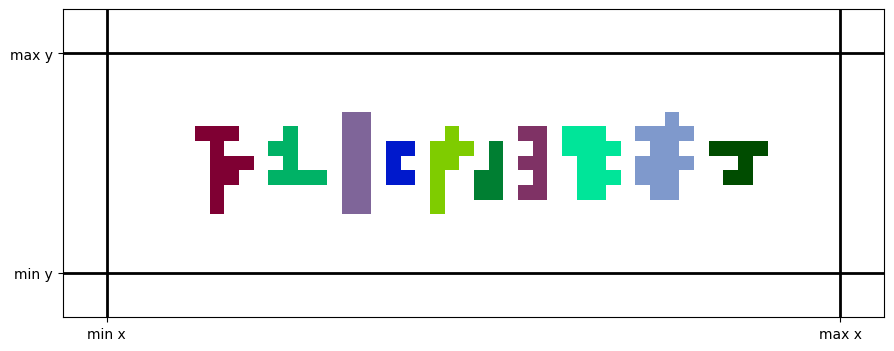

### Solutions
A solution to a cutting stock problem instance requires specifying where shapes are placed on the stock. A shape's placement on the stock can be defined by a translation and a rotation. Therefore, a solution consists of providing a translation and rotation for every shape.

A problem instance may have many, many different possible solutions. As you likely learned in class, the ability to determine which solutions are better than others is critical to the optimization process. Since the goal of the cutting stock problem is to minimize the length of stock used, we can score solutions by using a simple function that subtracts the length of stock used from the total length available:

<center>$score(solution) = available - used$</center>

where $available$ is the length of stock in the problem instance, and $used$ is the length of stock used by the solution. Then, intuitively, a solution's score represents how "good" it is; a higher score means a better solution. We calculate $used$ as the range between the leftmost and rightmost cells occupied by the solution. The arrangement shown above uses 39 length, out of 50 available. As a solution, it would have a score of 11.

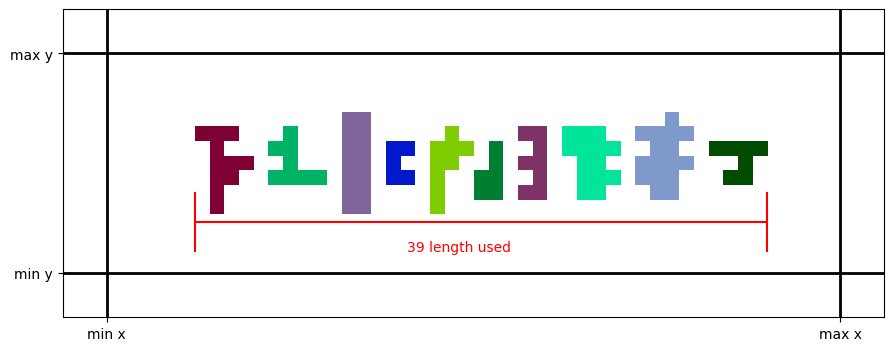

There are also many ways you could try to place shapes on the stock that simply don't make sense. For this problem, that would be any solution where shapes overlap or fall out-of-bounds. We call these invalid solutions, and assign them an arbitrary negative score (`-99999`) rather than following the above equation.

## Implementation
Alright, onto the actual code. We'll only discuss the components that you should interact with, and will leave out unnecessary discussion of the lower-level implementation. If you get any errors that look like `NameError: name 'x' is not defined`, where `x` is one of the things we are about to discuss, you either have a typo or restarted your Python interpreter kernel (basically rebooting the program) and should re-run earlier code cells.

To avoid overloading you with more information than you really need, we will defer explanation of our configuration until the next assignment. We will provide you with all the code samples you'll need, so don't worry if you don't understand everything about how it's being used.

### Aside: Jupyter Notebook Hygiene
Note that a lot of the example cells in this course include `del` statements at the end which clear local variables. Notebook cells are not independent programs; variables persist between cell executions unless you restart the kernel. Careless reuse of variables defined in notebook cells is a frequent source of bugs. Examples of this include reusing the values of random variables, or appending to an existing list when you should have started a new one. There are some reasonable exceptions to this, like collecting your experimental data in one cell then conducting your analysis in another, or defining a function in one cell and running it in another\*. But you *must* be careful to not accidentally reuse variables in ways you didn't intend to! You don't need to `del` your variables (and it's generally a very unusual practice), we simply do it in these tutorials to ensure you can't haphazardly reuse example variables.

\*When doing this, remember that any changes you make to a function only apply if you execute the cell defining the function again. It's good practice to make a cell containing only functions, so you can execute it after any changes, and keep the actual function calls in a separate cell.

### Problem Specification
We define the cutting stock problem in terms of two variables: `shapes` and `bounds`, respectively describing the shapes and the stock they must be placed on. These may be found in `configs/1a_config.txt`. Without getting into implementation details, `shapes` is a list, where each element describes one shape. Its only importance to you is its length, `len(shapes)`. `bounds` defines the dimensions of the stock:

* `bounds[0][0]` is $x_{min}$, the minimal x-coordinate on the stock (the left-hand boundary)
* `bounds[0][1]` is $x_{max}$, one plus the maximal x-coordinate on the stock (the right-hand boundary)
* `bounds[1][0]` is $y_{min}$, the minimal y-coordinate on the stock (the bottom boundary)
* `bounds[1][1]` is $y_{max}$, one plus the maximal y-coordinate on the stock (the top boundary)

In other words, the stock consists of all cooordinates such that `bounds[0][0] <= x < bounds[0][1]` and `bounds[1][0] <= y < bounds[1][1]`. Equivalently, this is the set $\{(x, y)|x\in[x_{min}, x_{max})\ \&\ y\in[y_{min}, y_{max})\}$.

### LinearGenotype
We've provided a partially-complete class (`LinearGenotype`) for your solution implementation. This is where you will begin to have considerable freedom in your implementations; you can use whatever data structures you want, so long as they meet our requirements. This is a good time to remind you that code practices contribute to your score, that your code will be meticulously graded _by hand_, and that we appreciate and remember students who consistently submit clean code.

As previously discussed, a solution to a cutting stock problem specifies a translation and rotation for every shape in the problem. Since the stock is 2-dimensional, translation is an `(x, y)` coordinate pair, where `x` and `y` are both in the bounds specified above. We will represent rotation with either `0`, `1`, `2`, or `3`, denoting a number of 90-degree clockwise turns. You will implement the translation and rotation for a shape as a single indexable data structure of the form `(x, y, r)`. That is, index `0` is the `x` value, index `1` is the `y` value, and index `2` is the rotation value. We recommend (but do not require) that you use a `tuple` or `list` for this data structure. In EC vocabulary this general structure is called a gene, while a specific instance of a gene is an allele.

A gene describes the placement for one shape, but a solution to a cutting stock problem requires defining the placement of each shape. Therefore, a solution must be implemented such that `len(solution) == len(shapes)`, and `solution[i]` is a gene as described above. Then, we will use `solution[i]` to define the placement of `shapes[i]`. As with the genes, we recommend (but do not require) that you use a `tuple` or `list` for your solution data structure. In EC vocabulary, this solution structure is a fixed-length linear genotype. Fixed-length means there is a static number of loci (plural form of _locus_), which is a location for one gene, while linear is simply because the vector is 1-dimensional.

### LinearGenotype.random_initialization
That was a lot of information; good job for making it this far! For your first implementation task, implement the `LinearGenotype.random_initialization` method (found in the `linear_genotype.py` file) to get the following cell to work, and pass every test as `True`. This method should create a randomly-initialized solution as described above, where every value is chosen uniformly from its valid range. This function should store the generated solution in the `self.genes` member variable. *You can ignore the other methods of the `LinearGenotype` class until Assignment 1b.*

If you're not sure where to start in your implementation, focus on figuring out how to generate the three values for a single allele. Once you've got that, making a full solution just requires generating `len(shapes)` different alleles.

The following cell will run some basic tests to check your implementation. Passing these tests does not guarantee your implementation is perfect (particularly, it doesn't check that your distribution is uniform), but is just a few basic guidelines.

In [29]:
# Config magic; don't worry about this variable too much
config = read_config('configs/1a_config.txt', globals(), locals())

test_solution = LinearGenotype()

# We want this function to work!
test_solution.random_initialization(**config['problem'])

# You can uncomment this line to see your solution, for debugging
# May or may not work depending on your implementation
# print(test_solution.genes)


# The following attempts to validate your implementation
print('The function did something?', test_solution.genes is not None)
print('Was the solution the right length?', len(test_solution.genes) == len(config['problem']['shapes']))
print('Is each element in the solution length 3?', all([len(x) == 3 for x in test_solution.genes]))

def check_bounds(placement, bounds):
    return bounds[0][0] <= placement[0] < bounds[0][1] and\
           bounds[1][0] <= placement[1] < bounds[1][1]
print('Did the solution adhere to the bounds?',\
      all([(check_bounds(x, config['problem']['bounds'])) for x in test_solution.genes]))
print('Are rotations valid?', all([x[2] in [0, 1, 2, 3] for x in test_solution.genes]))

# Make a different random solution
another_solution = LinearGenotype()
another_solution.random_initialization(**config['problem'])

# This has a very small chance of failing for correct implementations
found = False
for i in range(len(test_solution.genes)):
    for j in range(3):
        if test_solution.genes[i][j] != another_solution.genes[i][j]:
            found = True
            break
print('Does each call produce different solutions?', found)

del config, test_solution, check_bounds, another_solution, found

The function did something? True
Was the solution the right length? True
Is each element in the solution length 3? True
Did the solution adhere to the bounds? True
Are rotations valid? True
Does each call produce different solutions? True


### base_fitness_function
The final component you will need for this notebook is `base_fitness_function`. You need to pass it a solution and some values from the config (we will show an example in a bit). `base_fitness_function` returns a dictionary containing two values:

* The solution's score, calculated as we described previously while explaining the cutting stock problem. You may have noticed we're using the term fitness function, rather than scoring function. As may have already been covered in lectures depending on when you read this, in EC vocabulary we would call a solution's score its fitness. We will stick to that terminology for the rest of the course.
* A function that you can use later on to generate a visualization of the shapes placed on the stock. The visualization will be shown in the notebook outputs, and you can pass a string as keyword argument `path` for it to also save the file to that path.

These are stored under the keys `'fitness'` and `'visualize'`, respectively.

Read and execute the next cell to see an example of how to use `base_fitness_function` and the dictionary it returns, using solutions produced by your random initialization. This cell will evaluate your solution, print its fitness, and show a visualization for your solution. The fitness is almost certainly _very_ poor, and the visualization will likely include overlapping shapes and/or shapes that are partially out-of-bounds -- *that is completely normal*. You're making a very dumb random initialization that doesn't understand anything about the problem. Most of the solutions it generates will be invalid. It could take you hundreds of attempts to find a valid solution, so don't waste too much time trying! And, as a reminder, don't try to make a more clever algorithm. This is a random solution generator with no problem knowledge.

Fitness: 4


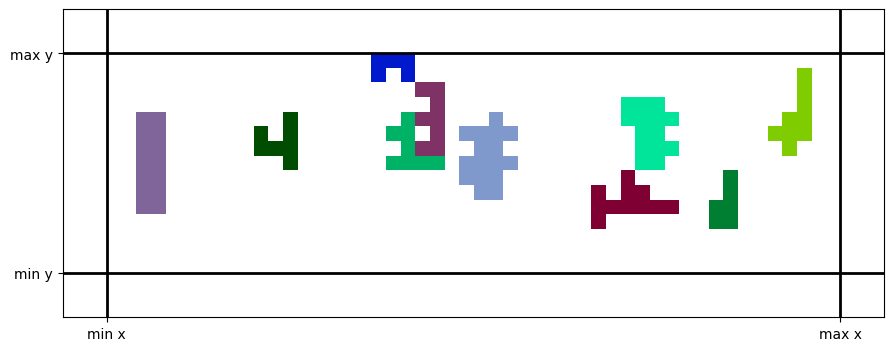

In [136]:
# Config magic; don't worry about this variable too much
config = read_config('configs/1a_config.txt', globals(), locals())

# Initialize a solution
solution = LinearGenotype()
solution.random_initialization(**config['problem'])

# Call the fitness function on the solution
output = base_fitness_function(solution.genes, **config['problem'])

# Save the output values into the solution variable
solution.fitness = output['fitness']
solution.visualize = output['visualize']

print('Fitness:', solution.fitness)

# You can visualize the solution by calling the returned function
solution.visualize()

# If we wanted to save the visualization to a file, we could have used:
# solution.visualize(path = 'my/file/path.png')

del config, solution, output

In EC terminology, we refer to each call of the fitness function as an evaluation (eval). Keeping track of the number of evals is very important, since it is used as a fair metric for comparing algorithms. If one algorithm took ten seconds to solve a problem on a supercomputer, and another algorithm took ten weeks on a laptop, it's unfair to say the first algorithm was better just because it took less time. Instead, we use evals as the basic unit for measuring the cost of an algorithm (you may hear this concept referred to as *sample efficiency* in general AI jargon).

In order to perform fair comparisons, all experimental runs in this assignment series will consist of one million evaluations. This way we can say that all algorithms were given the same amount of resources.

## Random Search Algorithm
As opposed to the more deliberate generate-and-test algorithms you will be creating later in this course, for this assignment you need only implement a random search: a "blind" algorithm that generates solutions randomly, without using any information about previously-evaluated solutions or their fitnesses. At this point, you have everything you need to write such an algorithm! Write a loop to generate new random solutions, evaluate them, and keep track of the best solution seen so far. If you feel lost, remember to look at how we evaluated solutions in the last few cells!

Implement your random search in the next cell. You can change the parameters and/or return value(s) of the function; we've just provided it now as a basic template to get you started.

In [326]:
from math import inf

def random_search(num_evaluations, config):
    best_fitness = -inf
    run_data = [[]]
    i = 0
    # Search through and evaluate num_evaluations different random solutions
    # using the functions we showed in the previous cells:
    
    for i in range(num_evaluations):
        solution = LinearGenotype()
        solution.random_initialization(**config['problem'])
        output = base_fitness_function(solution.genes, **config['problem'])
        solution.fitness = output['fitness']
        if (output['fitness'] > best_fitness):
            best_fitness = output['fitness']
            run_data.append(best_fitness)
            run_data[0].append(i)

    if (run_data[1] < 0): run_data[1] = 0

    # For the full experiment in the next section, you will need to collect and return data.
    # Feel free to ignore it for now, and you can come back to modify this function afterwards.
    # You may add any return values or parameters you want -- change this function however you wish.
    return best_fitness, run_data
    

Now run the next cell to test your function. This may take a minute or two to run. **If you ever change the function in the previous cell, make sure to execute that cell again so the changes get loaded by the interpreter!** Otherwise, the changes won't take effect in other cells.

In [327]:
# Calling your function and printing the outputs
config = read_config('configs/1a_config.txt', globals(), locals())
num_runs = 10
num_evaluations = 10000 # Smaller eval count, to not waste your time
current_result = [[]]
best_result = (0, [0])
best_of_each_run = []
for i in range(num_runs):
    current_result = random_search(num_evaluations, config)
    best_of_each_run.append(current_result[0])
    print(i + 1)
    if current_result[0] > best_result[0]: 
        best_result = current_result
        
print('\n')    
print(best_result)
print(best_of_each_run)

del num_evaluations, config

1
2
3
4
5
6
7
8
9
10


(24, [[0, 147, 500, 915], 0, 4, 10, 24])
[20, 24, 16, 16, 17, 15, 18, 13, 18, 16]


## Full Random Search Experiment
**IMPORTANT**: Before continuing, read the instructions here very carefully. You will need to change your function to record more data! You don't want to start your searches, wait several hours for them to finish, then find out you didn't actually record everything you need!

Using the code you wrote above, restart and run a random search with 1,000,000 evaluations 30 times (this can take several hours of computation). For each of the 30 runs, record the highest fitness encountered during the run. This data will be used later for statistical analysis.

Visualize the solution with the highest fitness across all runs. Example code for visualizing solutions can be found earlier in this notebook.

For the run that produced the highest fitness of all 30 runs, record data to produce a stairstep plot demonstrating the progress of this run as the search was performed. That is, plot the number of evaluations vs the greatest fitness value seen so far in the run. You should log the data used to generate the plot to a file in the `data` subdirectory. For reference, the stairstep plot should look something like this:

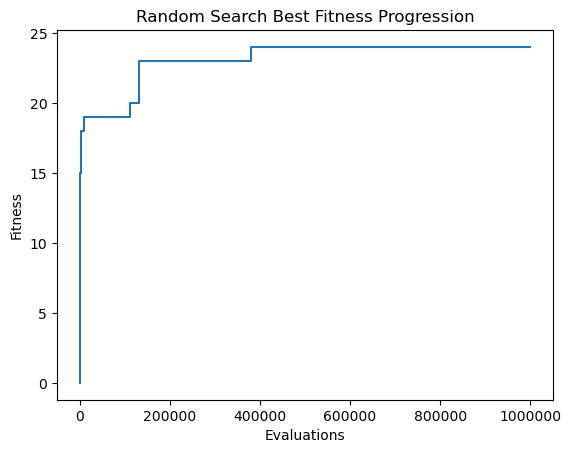

To reiterate, you will need:
* The highest fitness encountered in each run
    * 30 numbers, 1 per run
* Visualization of the best solution in the experiment
* Data for generating the stairstep plot
    * Generated from the run that produced your best solution
    * What this data should be, and how to record it, is left for you to decide. We will accept anything that can produce a complete & correct plot.
        * HINT: You need to record the requisite data during every run! You can't go back and record data after the run is finished!

Look at the very end of the notebook for a guide on multiprocessing, which can save you a lot of time!

Now, conduct your full 30-run experiment in the following cell:

In [331]:
num_runs = 30
num_evaluations = 1000000
config = read_config('configs/1a_config.txt', globals(), locals())

temp_run = [[]]
best_run = (0, [0])
best_of_each_run = []

# Sample function call for one run:
# random_search(num_evaluations, config)


# Write your random search experiment here and record data as described above
for i in range(num_runs):
    temp_run = random_search(num_evaluations, config)
    best_of_each_run.append(temp_run[0])
    if temp_run[0] > best_run[0]: 
        best_run = temp_run
        
    print(i + 1)

# Assign your data for statistical analysis to this variable
# It should be the highest fitness value seen in each run
stats_data = best_of_each_run

# Writing your data to a file
with open('data/random_results.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')
        
with open('data/best_results.txt', 'w') as f:
    for num in best_run:
        f.write(' '.join([str(num)]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


# Preparing the Report
Now that you've completed the implementation of random search, you need to use the data you've generated to create the report requested in the assignment description document. This report requires statistical analysis and a stairstep plot, which we will walk through here.

## Statistical Analysis
Your statistical analysis will be comparing the performance of your random search to the data found in `mystery_data.txt`. That data is drawn from 30 runs of a different cutting stock algorithm, and the values represent the best fitness found during each run of that algorithm. You should have collected analogous data from your random search, as described above.

We will perform statistical analysis using independent t-tests without assuming equal variance. This is accomplished by using the function `stats.ttest_ind(sample1, sample2, equal_var=False)` from the `scipy` package. This will return an object which includes a `pvalue` member. As you will recall from your statistics course, statistical tests are designed so you can compare the $p$-value to a predetermined threshold ($\alpha$) in order to accept or reject the null hypothesis. For this class, $\alpha = 0.05$. You should also recall that the null hypothesis for a t-test is that the two sampled distributions have the same true mean. Since the populations here represent the best fitness values found by different algorithms, the null hypothesis is that the two algorithms are equally effective at solving the problem.

We've provided some code below to do the computations, you just need to interpret the results. Report the $p$-value displayed by this cell, compare it to $\alpha = 0.05$, and use this information to draw conclusions about the relative performance of your random search and the mystery algorithm. As an example of what we're looking for, you could say something like `p is (less/greater) than alpha, meaning the two algorithms (do/do not) have statistically significant differences in performance`. If they do have differences in performance, state which one performs better and how you came to that conclusion. In addition, your report should also include the mean and standard deviation for each dataset.

In [332]:
import statistics
from scipy import stats

# Reading the data from your experiment that we wrote earlier
with open('data/random_results.txt', 'r') as f:
    my_data = [int(line) for line in f.readlines()]

print('my data mean:', statistics.mean(my_data))
print('my data stdv:', statistics.stdev(my_data))

# Reading the mystery data for you to compare against
with open('data/mystery_data.txt', 'r') as f:
    mystery_data = [int(line) for line in f.readlines()]

print('mystery data mean:', statistics.mean(mystery_data))
print('mystery data stdv:', statistics.stdev(mystery_data))

test_result = stats.ttest_ind(my_data, mystery_data, equal_var=False)
print('p-value:', test_result.pvalue)

my data mean: 25.033333333333335
my data stdv: 1.5643293888377885
mystery data mean: 32.36666666666667
mystery data stdv: 0.6686751354593717
p-value: 8.308313179385359e-25


## Stairstep Plot
Again, the data used for your plot should demonstrate the search progress of the run that produced the highest fitness. The x-axis should be the number of evaluations, and the y-axis should be fitness. The plotted value is the highest fitness seen so far during the run. The stairstep plot can be generated with the data you've collected using `matplotlib`'s `plt.plot()`\*. In the following cell, set `figure_y_values` to the y-values for the stairstep plot, one per eval, and run the cell.

\*You can also use `plt.step()` if you wish, but the data format it takes is slightly different.

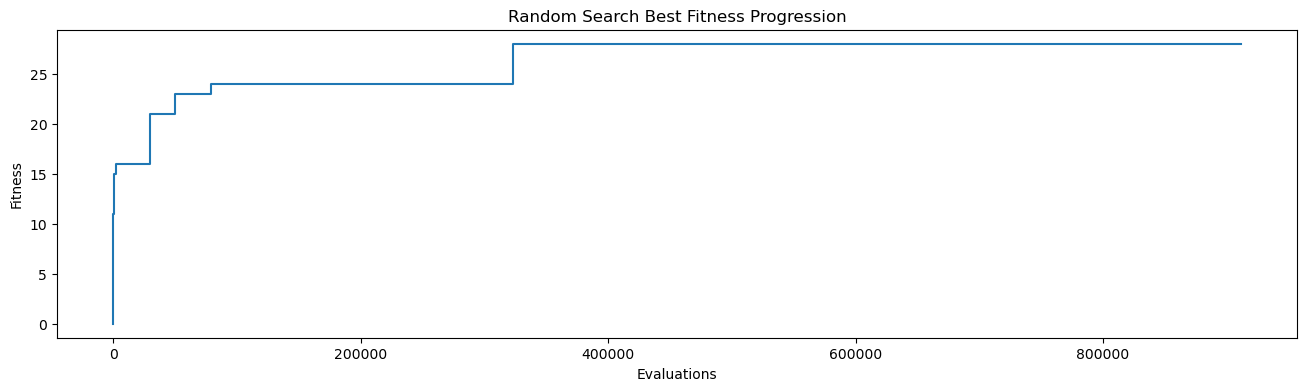

In [348]:
# The first cell already imported matplotlib.pyplot as plt

with open("data/best_results.txt", "r") as file:
    text_file_content = file.read()
    python_list = eval(text_file_content[2:])  # Remove the leading "28"
    eval_count = python_list[0]
    eval_result = python_list[1:]

# figure_y_values needs to be set appropriately!
figure_y_values = eval_result

# x values are 1..num_evaluations
figure_x_values = [eval_count[i] for i in range(len(figure_y_values))]

fig, ax = plt.subplots()
stairs = plt.step(eval_count, eval_result)
#ax.plot(figure_x_values, figure_y_values)
#ax.xlim([0, 1000000])
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness', title = 'Random Search Best Fitness Progression')
plt.show()

# In addition, you need to log the data used to generate your plot
# to a file in the data subdirectory. Do this below.


### Optional: Multiprocessing
While not strictly required, you may save a tremendous amount of time by using multiprocessing. Luckily, since you have to do 30 independent runs, it should be very easy to parallelize. If you're interested in saving yourself a lot of time, use the following template!

```py
from multiprocessing.pool import Pool
...
...
...
with Pool() as pool:
    args = [[num_evaluations, config] for _ in range(num_runs)]
    run_results = list(pool.starmap(random_search, args))
```
This is equivalent to `run_results = [random_search(num_evaluations, config) for _ in range(num_runs)]`, but it takes advantage of your computer's multiple cores to conduct multiple runs in parallel! The speedup should be pretty much linear.

For the Python experts: if you want to parallelize in some other way (such as at evaluations, rather than at runs), you can do that however you wish.